In [ ]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch import nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Load your preprocessed dataset
data1 = pd.read_csv('D:/kcc_dataset.csv')

In [ ]:
# Filter the dataset
f_df = data1[(data1['Crop'].str.isnumeric() == False) & (data1['Crop'] != 'Others') & 
             (data1['QueryType'].str.isnumeric() == False) & (data1['QueryType'] != 'Others')]
df= pd.DataFrame(f_df)
df = df[df['Year'] >= 2013]
# Create a new feature 'Crop_QueryType'
df["place"] = df['StateName'] + '_' + df['DistrictName']
data = df[['Month', 'Year', 'place', 'Crop', 'QueryType']]


In [ ]:
print(df)
print(data)

CROP WISE QUERYTYPE TRAINING

In [ ]:


# Encode QueryType as categorical variable
data['QueryType_code'] = data['QueryType'].astype('category').cat.codes

# Prepare input texts by using DistrictName and Crop_QueryType
data['text'] = data.apply(lambda row: f"{row['Month']} {row['place']} {row['Crop']} {row['QueryType']}", axis=1)

In [ ]:
# Tokenize the text inputs using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
inputs = tokenizer(data['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
# Extract labels for training (QueryType codes)
labels = torch.tensor(data['QueryType_code'].values, dtype=torch.long)

In [ ]:
# Split the dataset into training and testing sets
train_inputs, test_inputs, train_labels, test_labels, train_idx, test_idx = train_test_split(
    inputs['input_ids'], labels, data.index, test_size=0.2, random_state=42)
train_masks, test_masks = train_test_split(inputs['attention_mask'], test_size=0.2, random_state=42)

In [ ]:
# Create DataLoader for training and validation
batch_size = 16

train_data = TensorDataset(train_inputs, torch.tensor(train_masks), train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, torch.tensor(test_masks), test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# Initialize the DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=data['QueryType_code'].nunique())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


In [ ]:
# Set up the optimizer and loss function
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Training loop
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

        # Compute the loss
        loss = loss_fn(logits, b_labels)
        total_loss += loss.item()

        # Backward pass and update
        loss.backward()
        optimizer.step()

        if step % 1000 == 0:
            print(f"Epoch {epoch + 1}/{epochs} | Step {step}/{len(train_dataloader)} | Loss: {loss.item()}")

     # End time for the epoch
    # epoch_end_time = time.time()
    
    # Calculate average loss and time taken for the epoch
 Time Taken: {epoch_time:.2f} seconds")
        avg_train_loss = total_loss / len(train_dataloader)
    # epoch_time = epoch_end_time - epoch_start_time
    
    print(f"Epoch {epoch + 1}, Average Loss: {avg_train_loss}")#
    


Epoch 1/1 | Step 6000/915532 | Loss: 0.002130125416442752
Epoch 1/1 | Step 7000/915532 | Loss: 0.00012731247988995165
Epoch 1/1 | Step 8000/915532 | Loss: 0.0002920789993368089
Epoch 1/1 | Step 9000/915532 | Loss: 2.5189950974890962e-05
Epoch 1/1 | Step 10000/915532 | Loss: 0.0002047727321041748
Epoch 1/1 | Step 11000/915532 | Loss: 6.216885230969638e-05
Epoch 1/1 | Step 12000/915532 | Loss: 8.47478149808012e-05
Epoch 1/1 | Step 13000/915532 | Loss: 1.0929831660178024e-05
Epoch 1/1 | Step 14000/915532 | Loss: 2.804975702019874e-05
Epoch 1/1 | Step 15000/915532 | Loss: 2.073386167467106e-05
Epoch 1/1 | Step 16000/915532 | Loss: 1.1168199307576288e-05
Epoch 1/1 | Step 17000/915532 | Loss: 2.00625308934832e-05
Epoch 1/1 | Step 18000/915532 | Loss: 0.0001100663430406712
Epoch 1/1 | Step 19000/915532 | Loss: 2.5927965907612815e-06
Epoch 1/1 | Step 20000/915532 | Loss: 1.5124625178941642e-06
Epoch 1/1 | Step 21000/915532 | Loss: 0.00011443998664617538
Epoch 1/1 | Step 22000/915532 | Loss: 2.

NameError: name 'time' is not defined

In [ ]:
    avg_train_loss = total_loss / len(train_dataloader)
    # epoch_time = epoch_end_time - epoch_start_time
    
    print(f"Epoch {epoch + 1}, Average Loss: {avg_train_loss}")#

Epoch 1, Average Loss: 0.05677984567414616


In [110]:
# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask = b_input_ids.to(device), b_input_mask.to(device)
        
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(b_labels.cpu().numpy())

KeyboardInterrupt: 

In [ ]:
print(data.columns)

Index(['Month', 'place', 'Crop_QueryType', 'Crop_QueryType_code', 'text1'], dtype='object')


In [ ]:
# After prediction, use test_idx to reference the original data
#predictions_flat = [item for sublist in predictions for item in sublist]
predictions_flat=predictions

# Use the indices from test_idx to retrieve the original Month and DistrictName from the original data
predicted_data = pd.DataFrame({
    'Month': data.loc[test_idx, 'Month'].values, 
    'Place': data.loc[test_idx, 'place'].values,
    'Crop' : data.loc[test_idx, 'Crop'].values,
    'QueryType_code': predictions_flat
})
print(predicted_data)

KeyError: 'Crop'

In [ ]:
data['QueryType'] = data['QueryType'].astype('category')
predicted_data['QueryType']=predicted_data['QueryType_code'].apply(lambda x: data['QueryType'].cat.categories[x])
print(predicted_data)

KeyError: 'QueryType'

In [ ]:
# Predict most frequent Crop_QueryType for next year on a monthly basis
monthly_predictions = predicted_data.groupby(['Month', 'Place', 'Crop'])['QueryType'].apply(lambda x: x.value_counts().index[:10]).reset_index()
print(monthly_predictions)

        Month                       Place                  Crop  \
0           1     A AND N ISLANDS_NICOBAR       Ash Gourd Petha   
1           1     A AND N ISLANDS_NICOBAR              Chillies   
2           1     A AND N ISLANDS_NICOBAR        POULTRY  FARM    
3           1     A AND N ISLANDS_NICOBAR            Paddy Dhan   
4           1     A AND N ISLANDS_NICOBAR  Sugarcane Noble Cane   
...       ...                         ...                   ...   
337110     12  WEST BENGAL_WEST MEDINIPUR                  Teak   
337111     12  WEST BENGAL_WEST MEDINIPUR                Tomato   
337112     12  WEST BENGAL_WEST MEDINIPUR              Tuberose   
337113     12  WEST BENGAL_WEST MEDINIPUR            Watermelon   
337114     12  WEST BENGAL_WEST MEDINIPUR                 Wheat   

                                                QueryType  
0       Index(['Weather'], dtype='object', name=(1, 'A...  
1       Index(['Nutrient Management'], dtype='object',...  
2       Index([

In [113]:
monthly_predictions= monthly_predictions.explode('QueryType')
# Concatenate the QueryType values for each unique combination of Month and Place
top_n = 10  # Change this value to get top N Crop_QueryTypes
top_querytypes = (
    predicted_data.groupby(['Month', 'Place','Crop'])['QueryType']
    .apply(lambda x: x.value_counts().head(top_n).index.tolist())
    .reset_index()
)

# Rename columns for clarity
top_querytypes.columns = ['Month', 'Place','Crop', 'Top_QueryTypes']

# Save predictions to CSV with only Month, Place, and Crop_QueryType columns
top_querytypes.to_csv('D:/Objective 1 code/top_cropwise_querytypes_list.csv', index=False, header=True)

In [64]:
monthly_predictions= monthly_predictions.explode('QueryType')
# Concatenate the QueryType values for each unique combination of Month and Place
monthly_predictions = monthly_predictions.groupby(['Month', 'Place','Crop'])['QueryType'].apply(lambda x: ', '.join(x)).reset_index()

# Save predictions to CSV with only Month, Place, and Crop_QueryType columns
monthly_predictions[['Month', 'Place','Crop','QueryType']].to_csv('D:/Data/Top_predicted_cropwise_querytypes_in_India_111.csv', index=False, header=True)

In [65]:
# Flatten the predictions and true labels
predictions = np.array(predictions)
true_labels = np.array(true_labels)

In [66]:
# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TypeError: f1_score() got an unexpected keyword argument 'average'

In [ ]:
import numpy as np

def rmse(true_labels, predictions):
    return np.sqrt(np.mean((np.array(true_labels) - np.array(predictions)) ** 2))

def mae(true_labels, predictions):
    return np.mean(np.abs(np.array(true_labels) - np.array(predictions)))

def f1_score(true_labels, predictions):
    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fp = np.sum((np.array(true_labels) == 0) & (np.array(predictions) == 1))
    fn = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 0))
    
    # Calculate Precision and Recall
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    # Calculate F1-Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return f1

def recall(true_labels, predictions):
    # Calculate True Positives (TP) and False Negatives (FN)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fn = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 0))
    
    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    return recall

def precision(true_labels, predictions):
    # Calculate True Positives (TP) and False Positives (FP)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fp = np.sum((np.array(true_labels) == 0) & (np.array(predictions) == 1))
    
    # Calculate Precision
    return tp / (tp + fp) if (tp + fp) != 0 else 0

import numpy as np

def accuracy(true_labels, predictions):
    # Count the number of correct predictions
    correct = np.sum(np.array(true_labels) == np.array(predictions))
    # Calculate accuracy
    return correct / len(true_labels)

In [ ]:
# Calculate RMSE and MAE
rmse = rmse(true_labels, predictions)
mae = mae(true_labels, predictions)

# Calculate F1-Score and Recall
f1 = f1_score(true_labels, predictions)
recall = recall(true_labels, predictions)

accuracy= accuracy(true_labels, predictions)
precision= precision(true_labels, predictions)


In [ ]:
# # Create a confusion matrix
# conf_matrix = confusion_matrix(true_labels, predictions)

# # Plot the confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=data['QueryType'].cat.categories, 
#             yticklabels=data['QueryType'].cat.categories)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()


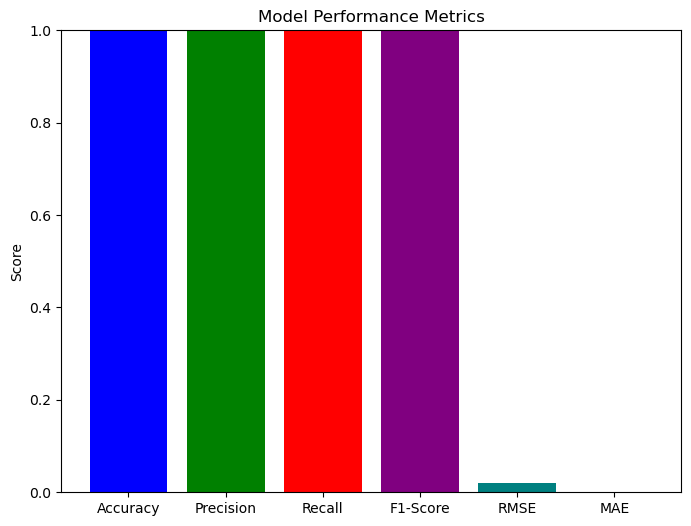


Model Performance Metrics:
      Metric     Value
0   Accuracy  1.000000
1  Precision  1.000000
2     Recall  1.000000
3   F1-Score  1.000000
4       RMSE  0.019335
5        MAE  0.000010


In [ ]:
# Create a bar plot for the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE', 'MAE']
values = [accuracy, precision, recall, f1, rmse, mae]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'Teal', 'orange'])
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# Display the metrics in a tabular format
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE', 'MAE'],
    'Value': [accuracy, precision, recall, f1, rmse, mae]
})
print("\nModel Performance Metrics:")
print(metrics_table)

# Save the metrics to a CSV file
metrics_table.to_csv('D:/Data/distilbert1_model_performance_metrics.csv', index=False)

#Training regarding the Crop_QueryType analysis#

In [ ]:
df["Crop_QueryType"] = df["Crop"] + "_" +df["QueryType"]
data=df[['Month','place','Crop_QueryType']]

data['Crop_QueryType_code'] = data['Crop_QueryType'].astype('category').cat.codes

# Prepare input texts by using DistrictName and Crop_QueryType
data['text1'] = data.apply(lambda row: f"{row['Month']} {row['place']} {row['Crop_QueryType']}", axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_37300\2764136759.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Crop_QueryType_code'] = data['Crop_QueryType'].astype('category').cat.codes
C:\Users\Admin\AppData\Local\Temp\ipykernel_37300\2764136759.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text1'] = data.apply(lambda row: f"{row['Month']} {row['place']} {row['Crop_QueryType']}", axis=1)


In [ ]:
# Tokenize the text inputs using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
inputs1 = tokenizer(data['text1'].tolist(), padding=True, truncation=True, return_tensors="pt")
# Extract labels for training (QueryType codes)
labels1 = torch.tensor(data['Crop_QueryType_code'].values, dtype=torch.long)


In [ ]:
# Split the dataset into training and testing sets
train_inputs1, test_inputs1, train_labels1, test_labels1, train_idx1, test_idx1 = train_test_split(
    inputs1['input_ids'], labels1, data.index, test_size=0.2, random_state=42)
train_masks1, test_masks1 = train_test_split(inputs1['attention_mask'], test_size=0.2, random_state=42)


In [ ]:
# Create DataLoader for training and validation
batch_size = 16

train_data1 = TensorDataset(train_inputs1, torch.tensor(train_masks1), train_labels1)
train_sampler1 = RandomSampler(train_data1)
train_dataloader1 = DataLoader(train_data1, sampler=train_sampler1, batch_size=batch_size)

test_data1 = TensorDataset(test_inputs1, torch.tensor(test_masks1), test_labels1)
test_sampler1 = SequentialSampler(test_data1)
test_dataloader1 = DataLoader(test_data1, sampler=test_sampler1, batch_size=batch_size)

C:\Users\Admin\AppData\Local\Temp\ipykernel_37300\419209612.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data1 = TensorDataset(train_inputs1, torch.tensor(train_masks1), train_labels1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_37300\419209612.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data1 = TensorDataset(test_inputs1, torch.tensor(test_masks1), test_labels1)


In [ ]:
# Initialize the DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=data['Crop_QueryType_code'].nunique())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Set up the optimizer and loss function
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()

c:\Users\Admin\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training loop
epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader1):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

        # Compute the loss
        loss = loss_fn(logits, b_labels)
        total_loss += loss.item()

        # Backward pass and update
        loss.backward()
        optimizer.step()

        if step % 1000 == 0:
            print(f"Epoch {epoch + 1}/{epochs} | Step {step}/{len(train_dataloader1)} | Loss: {loss.item()}")

   
    
    # Calculate average loss and time taken for the epoch
    avg_train_loss = total_loss / len(train_dataloader)
    
    
    print(f"Epoch {epoch + 1}, Average Loss: {avg_train_loss}, Time Taken: {epoch_time:.2f} seconds")
    

Epoch 1/1 | Step 0/915532 | Loss: 1.9406474828720093
Epoch 1/1 | Step 1000/915532 | Loss: 0.3966003358364105
Epoch 1/1 | Step 2000/915532 | Loss: 0.03674320876598358
Epoch 1/1 | Step 3000/915532 | Loss: 0.5051132440567017
Epoch 1/1 | Step 4000/915532 | Loss: 1.341935157775879
Epoch 1/1 | Step 5000/915532 | Loss: 1.1538422107696533
Epoch 1/1 | Step 6000/915532 | Loss: 0.0064475336112082005
Epoch 1/1 | Step 7000/915532 | Loss: 0.6357470750808716
Epoch 1/1 | Step 8000/915532 | Loss: 0.0025762412697076797
Epoch 1/1 | Step 9000/915532 | Loss: 0.31868141889572144
Epoch 1/1 | Step 10000/915532 | Loss: 0.02386941760778427
Epoch 1/1 | Step 11000/915532 | Loss: 1.0250197649002075
Epoch 1/1 | Step 12000/915532 | Loss: 0.0015231339493766427
Epoch 1/1 | Step 13000/915532 | Loss: 0.0030500770080834627
Epoch 1/1 | Step 14000/915532 | Loss: 1.0202518701553345
Epoch 1/1 | Step 15000/915532 | Loss: 0.28092917799949646
Epoch 1/1 | Step 16000/915532 | Loss: 0.0038572936318814754
Epoch 1/1 | Step 17000/915

NameError: name 'epoch_time' is not defined

In [ ]:
    avg_train_loss = total_loss / len(train_dataloader)
    
    
    print(f"Epoch {epoch + 1}, Average Loss: {avg_train_loss}") # Time Taken: {epoch_time:.2f} seconds")
    

Epoch 1, Average Loss: 0.05677984567414616


In [ ]:
# Evaluation
model.eval()
predictions1 = []
true_labels1 = []
with torch.no_grad():
    for batch in test_dataloader1:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask = b_input_ids.to(device), b_input_mask.to(device)
        
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions1.extend(preds)
        true_labels1.extend(b_labels.cpu().numpy()) 

KeyboardInterrupt: 

In [100]:
# After prediction, use test_idx to reference the original data
predictions_flat1 = predictions1

# Use the indices from test_idx to retrieve the original Month and DistrictName from the original data
predicted_data1 = pd.DataFrame({
    'Month': data.loc[test_idx, 'Month'].values, 
    'Place': data.loc[test_idx, 'place'].values,
    'Crop_QueryType_code': predictions_flat1
})
print(predicted_data1)

ValueError: All arrays must be of the same length

In [101]:
data['Crop_QueryType'] = data['Crop_QueryType'].astype('category')
predicted_data1['Crop_QueryType']=predicted_data1['Crop_QueryType_code'].apply(lambda x: data['Crop_QueryType'].cat.categories[x])
print(predicted_data1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_37300\301140935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Crop_QueryType'] = data['Crop_QueryType'].astype('category')


         Month                              Place  Crop_QueryType_code  \
0            9             UTTAR PRADESH_FATEHPUR                 5571   
1           12             ANDHRA PRADESH_NELLORE                 5554   
2            5                 RAJASTHAN_BHILWARA                 4410   
3           11          UTTAR PRADESH_KUSHI NAGAR                 7874   
4            9                  MAHARASHTRA_NASIK                 7553   
...        ...                                ...                  ...   
3662122      7                TAMILNADU_CUDDALORE                 5554   
3662123     12                     PUNJAB_PATIALA                 7893   
3662124     11                    BIHAR_DARBHANGA                 7889   
3662125      5  UTTAR PRADESH_GAUTAM BUDDHA NAGAR                 5917   
3662126      8              UTTAR PRADESH_ALIGARH                 1114   

                               Crop_QueryType  
0                          Paddy Dhan_Weather  
1              

In [102]:
# Predict most frequent Crop_QueryType for next year on a monthly basis
monthly_predictions1 = predicted_data1.groupby(['Month', 'Place'])['Crop_QueryType'].apply(lambda x: x.value_counts().index[:15]).reset_index()
print(monthly_predictions1)

      Month                          Place  \
0         1        A AND N ISLANDS_NICOBAR   
1         1        ANDHRA PRADESH_ANANTPUR   
2         1        ANDHRA PRADESH_CHITTOOR   
3         1   ANDHRA PRADESH_EAST GODAVARI   
4         1          ANDHRA PRADESH_GUNTUR   
...     ...                            ...   
7756     12     WEST BENGAL_North DINAJPUR   
7757     12            WEST BENGAL_PURULIA   
7758     12  WEST BENGAL_SOUTH 24 PARGANAS   
7759     12     WEST BENGAL_South DINAJPUR   
7760     12     WEST BENGAL_WEST MEDINIPUR   

                                         Crop_QueryType  
0     Index(['Chillies_Nutrient Management', 'Ash Go...  
1     Index(['Groundnut pea nutmung phalli_Plant Pro...  
2     Index(['Paddy Dhan_Plant Protection', 'Chillie...  
3     Index(['Paddy Dhan_Plant Protection', 'Black G...  
4     Index(['Chillies_Plant Protection', 'Chillies_...  
...                                                 ...  
7756  Index(['Potato_Plant Protection', '

In [105]:
top_n = 15  # Change this value to get top N Crop_QueryTypes
top_crop_querytypes = (
    predicted_data1.groupby(['Month', 'Place'])['Crop_QueryType']
    .apply(lambda x: x.value_counts().head(top_n).index.tolist())
    .reset_index()
)

# Rename columns for clarity
top_crop_querytypes.columns = ['Month', 'Place', 'Top_Crop_QueryTypes']

# Save to CSV
top_crop_querytypes.to_csv('D:/Objective 1 code/top_crop_querytypes_list.csv', index=False)

In [98]:
monthly_predictions1= monthly_predictions1.explode('Crop_QueryType')
# Concatenate the QueryType values for each unique combination of Month and Place
monthly_predictions1 = monthly_predictions1.groupby(['Month', 'Place'])['Crop_QueryType'].apply(lambda x: ', '.join(x)).reset_index()
# Predict most frequent Crop_QueryType for next year on a monthly basis
print(monthly_predictions1)

# Save predictions to CSV with only Month, Place, and Crop_QueryType columns
monthly_data1.to_csv('D:/Data/Places_crop_querytypes_in_India111.csv', index=False, header=True)

TypeError: sequence item 0: expected str instance, int found

In [ ]:
monthly_data1 = predicted_data1.groupby(['Month', 'Place'])['Crop_QueryType'].apply(lambda x: ', '.join(x)).reset_index()
print(monthly_data1)
# Save predictions to CSV with only Month, Place, and Crop_QueryType columns
monthly_data1.to_csv('D:/Data/Places_crop_querytypes_in_India111.csv', index=False, header=True)

      Month                          Place  \
0         1        A AND N ISLANDS_NICOBAR   
1         1        ANDHRA PRADESH_ANANTPUR   
2         1        ANDHRA PRADESH_CHITTOOR   
3         1   ANDHRA PRADESH_EAST GODAVARI   
4         1          ANDHRA PRADESH_GUNTUR   
...     ...                            ...   
7756     12     WEST BENGAL_North DINAJPUR   
7757     12            WEST BENGAL_PURULIA   
7758     12  WEST BENGAL_SOUTH 24 PARGANAS   
7759     12     WEST BENGAL_South DINAJPUR   
7760     12     WEST BENGAL_WEST MEDINIPUR   

                                         Crop_QueryType  
0     Chillies_Nutrient Management, Ash Gourd Petha_...  
1     Tomato_Plant Protection, BhindiOkraLadysfinger...  
2     Chillies_Plant Protection, Black Gram urd bean...  
3     Sugarcane Noble Cane_Weed Management, Paddy Dh...  
4     Banana_Nutrient Management, Bengal Gram GramCh...  
...                                                 ...  
7756  Maize Makka_Plant Protection, Potat

In [ ]:
# Flatten the predictions and true labels
predictions1 = np.array(predictions1)
true_labels1 = np.array(true_labels1)

In [ ]:

def rmse(true_labels, predictions):
    return np.sqrt(np.mean((np.array(true_labels) - np.array(predictions)) ** 2))

def mae(true_labels, predictions):
    return np.mean(np.abs(np.array(true_labels) - np.array(predictions)))

def f1_score(true_labels, predictions):
    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fp = np.sum((np.array(true_labels) == 0) & (np.array(predictions) == 1))
    fn = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 0))
    
    # Calculate Precision and Recall
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    # Calculate F1-Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return f1

def recall(true_labels, predictions):
    # Calculate True Positives (TP) and False Negatives (FN)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fn = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 0))
    
    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    return recall

def precision(true_labels, predictions):
    # Calculate True Positives (TP) and False Positives (FP)
    tp = np.sum((np.array(true_labels) == 1) & (np.array(predictions) == 1))
    fp = np.sum((np.array(true_labels) == 0) & (np.array(predictions) == 1))
    
    # Calculate Precision
    return tp / (tp + fp) if (tp + fp) != 0 else 0

import numpy as np

def accuracy(true_labels, predictions):
    # Count the number of correct predictions
    correct = np.sum(np.array(true_labels) == np.array(predictions))
    # Calculate accuracy
    return correct / len(true_labels)

In [ ]:
# Calculate RMSE and MAE
rmse = rmse(true_labels1, predictions1)
mae = mae(true_labels1, predictions1)

# Calculate F1-Score and Recall
f1= f1_score(true_labels1, predictions1)
recall = recall(true_labels1, predictions1)

accuracy = accuracy(true_labels1, predictions1)
precision = precision(true_labels1, predictions1)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
rmse = np.sqrt(mean_squared_error(true_labels1, predictions1))
print(rmse)
mae = mean_absolute_error(true_labels1, predictions1)
print(mae)

210.56078117322159
10.487001050420169


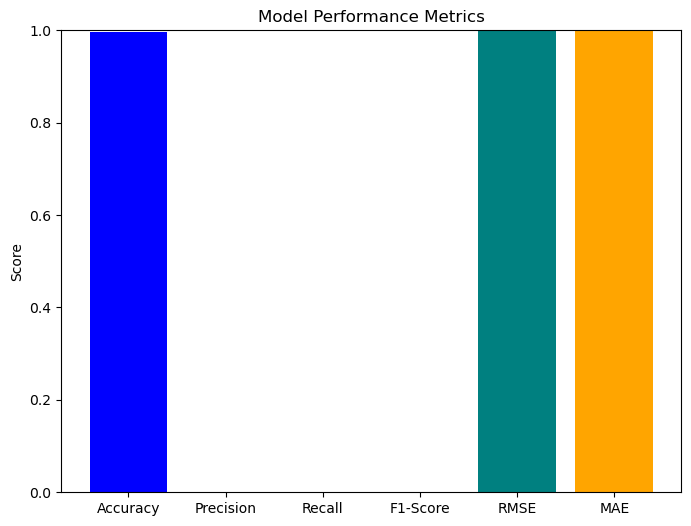


Model Performance Metrics:
      Metric       Value
0   Accuracy    0.996455
1  Precision    0.000000
2     Recall    0.000000
3   F1-Score    0.000000
4       RMSE  210.560781
5        MAE   10.487001


In [ ]:
# Create a bar plot for the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE', 'MAE']
values = [accuracy, precision, recall, f1, rmse, mae]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'Teal', 'orange'])
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# Display the metrics in a tabular format
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'RMSE', 'MAE'],
    'Value': [accuracy, precision, recall, f1, rmse, mae]
})


print("\nModel Performance Metrics:")
print(metrics_table)

# Save the metrics to a CSV file
metrics_table.to_csv('D:/Data/distilbert2_model_performance_metrics.csv', index=False)